# Moneyball

The goal of this analysis is to use supervised learning models to predict 2002 baseball runs allowed (RA), runs scored (RS), and wins (W) using 1962-2001 baseball statistics. We will be comparing the different learning models to get a better understanding of different models' performance.

In [1594]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import preprocess_data
plt.style.use("seaborn")
%matplotlib inline

## Reading in the preprocessed baseball data

In [1595]:
preprocess_data.df3.shape

(784, 11)

In [1596]:
data = preprocess_data.df3
data.head(3)

,RS,RA,W,OBP,SLG,BA,OOBP,OSLG,Year,Team,RD
300,851,644,99,0.341,0.433,0.282,0.314,0.392,2002,ANA,207
301,819,674,98,0.346,0.423,0.267,0.305,0.397,2002,ARI,145
302,708,565,101,0.331,0.409,0.260,0.313,0.364,2002,ATL,143


In [1597]:
# baseball stats between 1962 - 2002
data["Year"].unique()

array([2002, 2001, 2000, 1999, 1998, 1997, 1996, 1993, 1992, 1991, 1990,
       1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1980, 1979, 1978,
       1977, 1976, 1975, 1974, 1973, 1971, 1970, 1969, 1968, 1967, 1966,
       1965, 1964, 1963, 1962])

In [1598]:
# split dataset into pre- and post- 2002 datasets, for comparative analysis later
pre_2002 = data[data["Year"]<2002]
post_2002 = data[data["Year"]==2002]

In [1599]:
# 1962 - 2001
pre_2002["Year"].unique()

array([2001, 2000, 1999, 1998, 1997, 1996, 1993, 1992, 1991, 1990, 1989,
       1988, 1987, 1986, 1985, 1984, 1983, 1982, 1980, 1979, 1978, 1977,
       1976, 1975, 1974, 1973, 1971, 1970, 1969, 1968, 1967, 1966, 1965,
       1964, 1963, 1962])

In [1600]:
# 2002
post_2002["Year"].unique()

array([2002])

## Moneyball Analysis Overview

The analysis will be based on the estimations provided by the featured film "Moneyball (2011)". The film is based on Paul DePodesta's (a.k.a Peter Brand played by Jonah Hill) application of Bill James's Sabermetrics to the Oakland A's 2002 season. Sabermetrics is the analysis of baseball statistics in order to measure in-game activity. 

### Pythagorean Expectation Formula
A sports analytics formula created by Bill James that is designed to estimate the number of wins a baseball team should win based on the number of runs they scored (RS) and allowed (RA). A team wins if runs scored is higher than the opposite team's runs scored.

In [1601]:
%%latex
$$Win\,Ratio = \frac{(Runs\,Scored)^2}{(Runs\,Scored)^2 + (Runs\,Allowed)^2}$$

<IPython.core.display.Latex object>

A baseball team needs to play 162 games before the playoff season. DePodesta predicted that a team would need about 99 wins to confidently secure a spot in the playoffs.

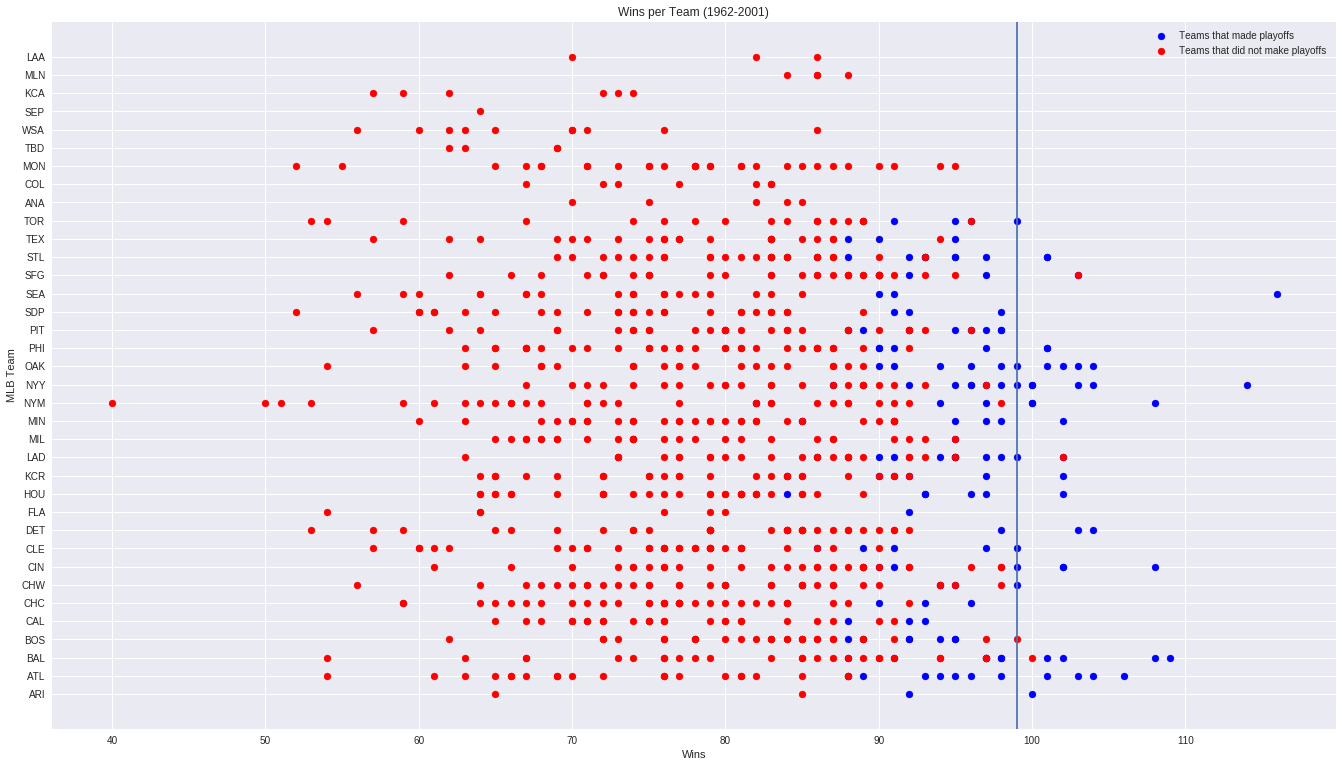

In [1602]:
# visualizing DePodesta's win estimation
mb_data = preprocess_data.df_copy
mb_data = mb_data[mb_data["Year"]<2002]
plt.rcParams['figure.figsize'] = (23,13)
mb_made_playoffs = mb_data[mb_data["Playoffs"]==1]
mb_no_playoffs = mb_data[mb_data["Playoffs"]==0]

plt.scatter(mb_made_playoffs["W"],mb_made_playoffs["Team"],color="blue",label="Teams that made playoffs")
plt.scatter(mb_no_playoffs["W"],mb_no_playoffs["Team"],color="red",label="Teams that did not make playoffs")
plt.axvline(x=99)
plt.title("Wins per Team (1962-2001)")
plt.xlabel("Wins")
plt.ylabel("MLB Team")
plt.legend()
plt.show()

In [1603]:
mb_po = mb_data[(mb_data["W"]>=99)&(mb_data["Playoffs"]==0)]
print("Years: ",mb_po["Year"])
print("Teams: ",mb_po["Team"])

Years:  530     1993
821     1980
874     1978
1222    1962
Name: Year, dtype: int64
Teams:  530     SFG
821     BAL
874     BOS
1222    LAD
Name: Team, dtype: object


The graph shows the number of teams that made it to the playoffs after playing 162 games between 1962-2001. The vertical line represents DePodesta's 99 win estimation. The estimation appears to be fairly accurate with only 3 teams not being able to make playoffs after 99 wins. It also looks like the 3 outliers appear to be centered in years pre-1990 which could indicate a different standard of playoff qualifications. Therefore, it is safe to conclude that 99 wins is a safe cutoff point for a guaranteed spot in the playoffs.

### Using pythagorean expectation formula to estimate RS & RA

In [1604]:
%%latex
$$\frac{99\,wins}{162\,games} = 0.61\,win\,ratio$$

<IPython.core.display.Latex object>

In [1605]:
%%latex
$$\frac{(814)^2}{(814)^2+(645)^2} = 0.6143$$

<IPython.core.display.Latex object>

Looks like the base estimations for comparisons are the following:
1. Runs Scored (RS): 814
2. Runs Allowed (RA): 645
3. Wins (W): 99

### Some key baseball terminology:

On-Base Percentage (OBP): a statistic that measures how frequently a batter reaches base

Slugging Percentage (SLG): measure of the batting productivity of a hitter

Batting Average (BA): measures the performance of batter

Run Differential (RD): cumulative team statistic that combines offensive and defensive scoring (RS - RA). Can be used to predict the expected win total for a team.

In [1606]:
%%latex
$$Runs\,Differential\,(RD) = Runs\,Scored(RS)-Runs\,Allowed(RA)$$

<IPython.core.display.Latex object>

In [1607]:
%%latex
$$On\,Base\,Percentage\,(OBP) = \frac{Hits(H)+Walks(BB)+HitByPitch(HBP)}{AtBat(AB)+Walks(BB)+HitByPitch(HBP)+SacrificeFly(SF)}$$

<IPython.core.display.Latex object>

In [1608]:
%%latex
$$Slugging\,Percentage\,(SLG) = \frac{Single(1B) + (2*Double(2B)) + (3*Triple(3B)) + (4*HomeRun(HR))}{AtBat(AB)}$$

<IPython.core.display.Latex object>

In [1609]:
%%latex
$$Batting\,Average\,(BA) = \frac{Hits(H)}{AtBat(AB)}$$

<IPython.core.display.Latex object>

### Sources
1. https://en.wikipedia.org/wiki/Moneyball_(film)

2. https://en.wikipedia.org/wiki/Paul_DePodesta

3. https://en.wikipedia.org/wiki/Pythagorean_expectation

4. https://en.wikipedia.org/wiki/Major_League_Baseball_schedule

5. https://www.edx.org/course/analytics-edge-mitx-15-071x-3

6. https://en.wikipedia.org/wiki/Run_differential

7. https://www.kaggle.com/wduckett/moneyball-mlb-stats-19622012/home

8. https://en.wikipedia.org/wiki/On-base_percentage

9. https://en.wikipedia.org/wiki/Slugging_percentage

## Feature Engineering for Models (RS, RA, W)

We are going to create 3 models for the following target features:

1. Runs Scored (RS)

2. Runs Allowed (RA)

3. Wins

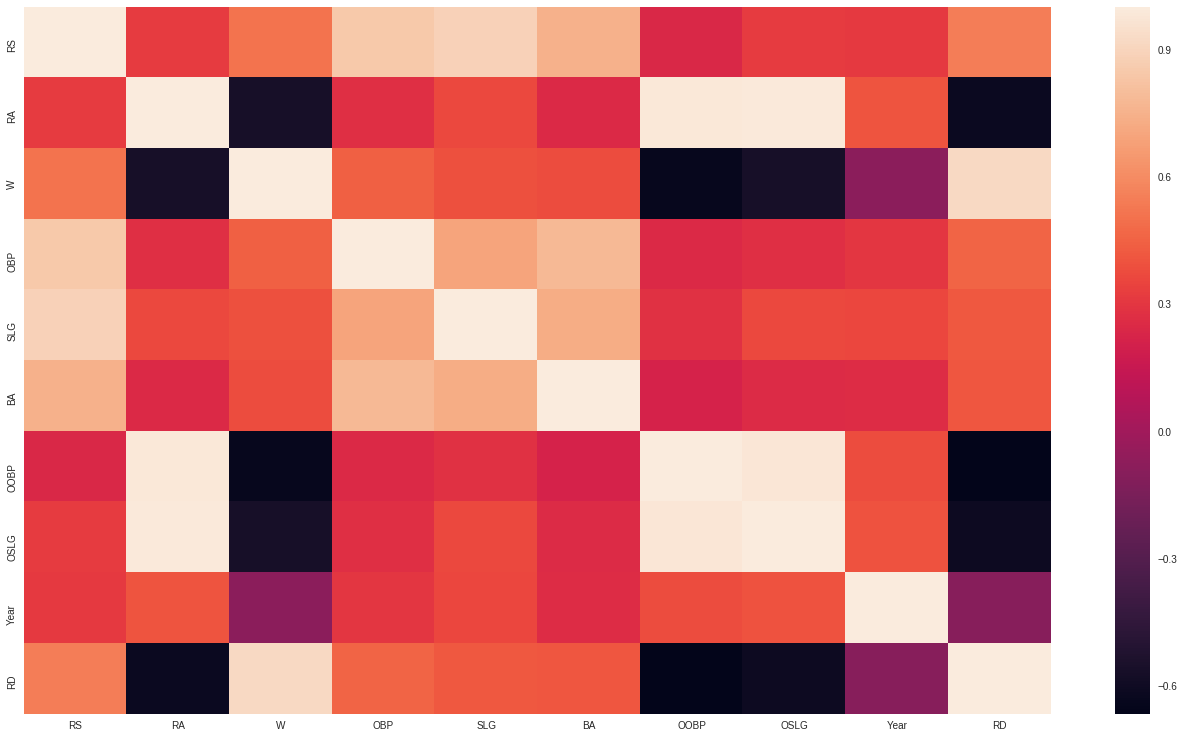

In [1610]:
# use correlation matrix to find features most correlated with the target features
corrmat = pre_2002.corr()
sns.heatmap(corrmat)
plt.show()

In [1611]:
display(corrmat)

,RS,RA,W,OBP,SLG,BA,OOBP,OSLG,Year,RD
RS,1.000000,0.322428,0.508873,0.844152,0.887560,0.751410,0.243532,0.320939,0.312768,0.549386
RA,0.322428,1.000000,-0.562632,0.276520,0.364495,0.246162,0.983270,0.991224,0.402767,-0.613807
W,0.508873,-0.562632,1.000000,0.445954,0.388901,0.381552,-0.636663,-0.563862,-0.083376,0.921040
OBP,0.844152,0.276520,0.445954,1.000000,0.696618,0.781816,0.252122,0.275279,0.304094,0.459933
SLG,0.887560,0.364495,0.388901,0.696618,1.000000,0.729160,0.282957,0.364121,0.359180,0.418479
BA,0.751410,0.246162,0.381552,0.781816,0.729160,1.000000,0.214265,0.253120,0.261876,0.409384
OOBP,0.243532,0.983270,-0.636663,0.252122,0.282957,0.214265,1.000000,0.978305,0.378053,-0.664837
OSLG,0.320939,0.991224,-0.563862,0.275279,0.364121,0.253120,0.978305,1.000000,0.401477,-0.607302
Year,0.312768,0.402767,-0.083376,0.304094,0.359180,0.261876,0.378053,0.401477,1.000000,-0.094679
RD,0.549386,-0.613807,0.921040,0.459933,0.418479,0.409384,-0.664837,-0.607302,-0.094679,1.000000


We are looking for features that have a strong positive correlation with our desired target variables (between 0.7 to 0.9). 

Here's the breakdown based on the correlation matrix:
1. Runs Allowed (RA) : Opponent's On-Base Percentage (OOBP), Opponent's Slugging Percentage (OSLG)

2. Runs Scored (RS) : On-Base Percentage (OBP), Slugging Percentage (SLG), Batting Average (BA)

3. Wins (W): Run Differential (RD)

## Multivariate Linear Regression
Initially using multivariate regression model based on features and target variable. However, will test linear assumptions before making predictions. 

In [1612]:
# may remove at end of project
def establish_parameters():
    # RS
    X_RS = pre_2002[["OBP","SLG","BA"]]
    y_RS = pre_2002["RS"]
    # RA
    X_RA = pre_2002[["OOBP","OSLG"]]
    y_RA = pre_2002["RA"]
    # W
    X_W = pre_2002[["RD"]]
    y_W = pre_2002["W"]
    return X_RS,y_RS,X_RA,y_RA,X_W,y_W

from sklearn.model_selection import train_test_split
def train_parameters(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    return X_train,X_test,y_train,y_test

### Runs Scored (RS)

In [1613]:
# establish features and target variables
X_RS = pre_2002[["OBP","SLG","BA"]]
y_RS = pre_2002["RS"]

In [1614]:
# graphing function for plotting linear relationship between features and target variable
def plot_scatter(X,y,y_axis_title,n_columns):
    fig,ax = plt.subplots(nrows=1,ncols=n_columns)
    y_ax = 0
    
    for col in X.columns:
        x_sort = X[col].values
        y_sort = y.values
        ax[y_ax].scatter(x_sort,y_sort)
        ax[y_ax].set_ylabel(y_axis_title)
        ax[y_ax].set_xlabel("{}".format(col))
        y_ax += 1
        
    fig.tight_layout()
    plt.show()

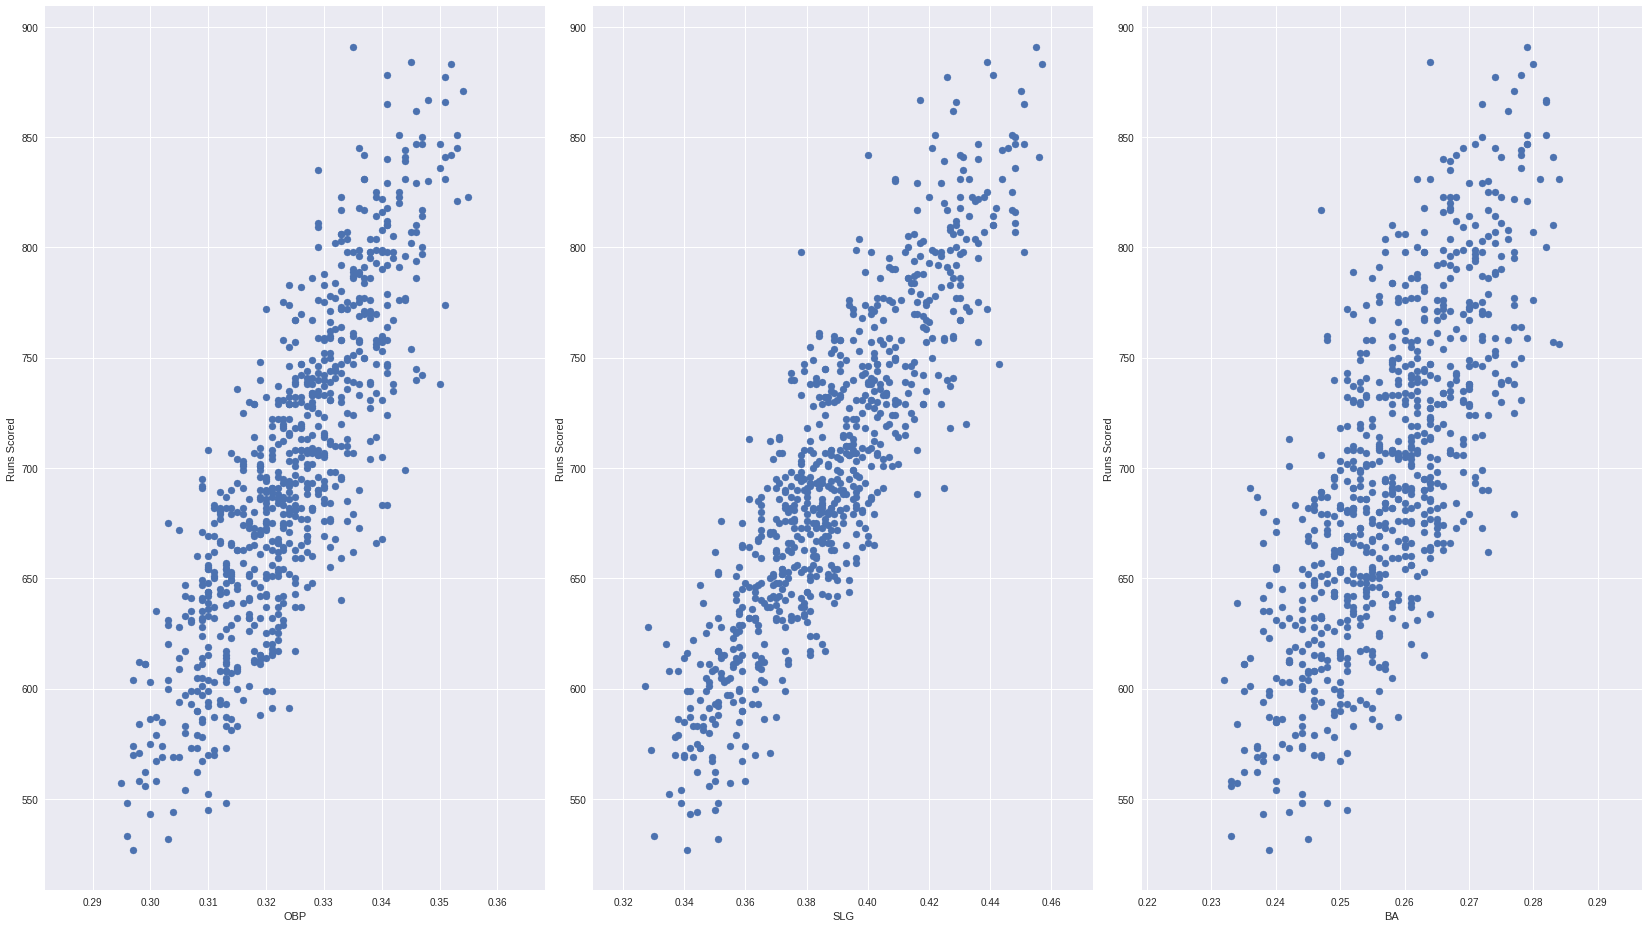

In [1615]:
plot_scatter(X_RS,y_RS,"Runs Scored",3)

There is a linear relationship between "Runs Scored" features and target variable

In [1616]:
# train & test set for RS
XRS_train,XRS_test,yRS_train,yRS_test = train_test_split(X_RS,y_RS,test_size=0.2)

In [1617]:
# fit linear regression to RS dataset
from sklearn.linear_model import LinearRegression
regr_RS = LinearRegression()
regr_RS.fit(XRS_train,yRS_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1618]:
# function for determining multivariate normality & homoscedasticity
def multi_norm_homo(X,X_col,regr_model,n_columns):
    actual = pre_2002[X_col]
    # fit full X features dataset into prediction (not test dataset)
    predicted = regr_model.predict(X)
    residual = actual - predicted
    
    plt.rcParams["figure.figsize"] = (12,6)
    fig,ax = plt.subplots(nrows=1,ncols=n_columns)
    
    ax[0].hist(residual)
    ax[0].set_title("Multivariate Normality (Residual Counts)")
    ax[0].set_xlabel("Residual")
    ax[0].set_ylabel("Count")
    
    ax[1].scatter(predicted,residual)
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Residual")
    ax[1].axhline(y=0)
    ax[1].set_title("Homoscedasticity (Residual vs. Predicted)")
    
    fig.tight_layout()
    plt.show()

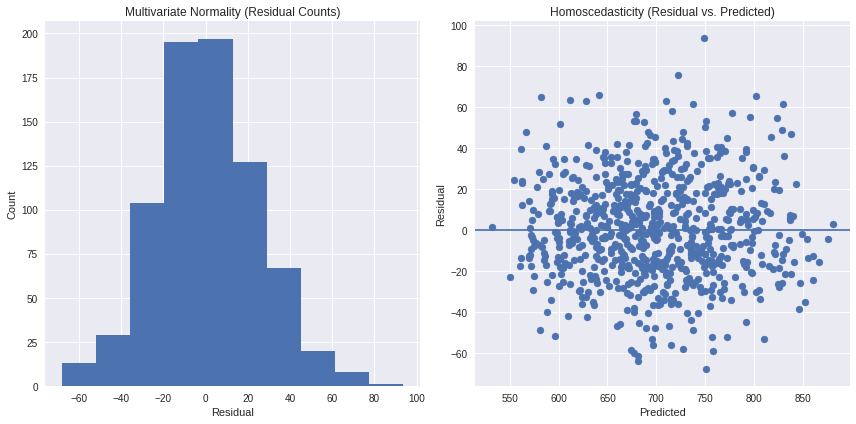

In [1619]:
multi_norm_homo(X_RS,"RS",regr_RS,2)

Appears the residual follows a normal distribution and there is a homoscedastic relationship between predicted and residual values. 

In [1620]:
# evaluating model performance (RS)
print("Coefficients:\n",regr_RS.coef_)
print("\nIntercept:\n",regr_RS.intercept_)
print("\nR-squared:\n",regr_RS.score(XRS_test,yRS_test))

Coefficients:
 [2805.9558611  1659.9774753  -408.64351362]

Intercept:
 -751.6281327230031

R-squared:
 0.8597302019856367


In [1621]:
# evaluating model using cross validation
from sklearn.model_selection import cross_val_score
cvs_RS = cross_val_score(estimator=regr_RS,X=X_RS,y=y_RS,cv=10)
print(cvs_RS)

[0.86535779 0.84744611 0.80942664 0.86304231 0.85538966 0.88536053
 0.90428955 0.84230533 0.90618462 0.8472854 ]


In [1622]:
# testing individual parameters
import statsmodels.formula.api as sm
linear_formula_RS = 'RS ~ OBP + SLG + BA'
lm_RS = sm.ols(formula=linear_formula_RS,data=pre_2002).fit()

In [1623]:
# check p-values for features and target variable, if p-value > 0.05 drop feature
lm_RS.pvalues

Intercept    2.662364e-130
OBP           1.296124e-87
SLG          8.965283e-144
BA            2.151727e-02
dtype: float64

BA has negative coefficient, may indicate multicollinearity. Lets remove for future data analysis.

In [1624]:
# remove BA
X_RS = pre_2002[["OBP","SLG"]]
XRS_train,XRS_test,yRS_train,yRS_test = train_test_split(X_RS,y_RS,test_size=0.2)
regr_RS.fit(XRS_train,yRS_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1625]:
# evaluating model performance (RS)
print("Coefficients:\n",regr_RS.coef_)
print("\nIntercept:\n",regr_RS.intercept_)
print("\nR-squared:\n",regr_RS.score(XRS_test,yRS_test))

Coefficients:
 [2549.78816306 1588.92768197]

Intercept:
 -746.487179178678

R-squared:
 0.8914596007980202


In [1626]:
cvs_RS = cross_val_score(estimator=regr_RS,X=X_RS,y=y_RS,cv=10)
print(cvs_RS)

[0.87079743 0.84803503 0.80515307 0.86227821 0.8559369  0.88224901
 0.90349773 0.84088214 0.90309005 0.84835513]


### Runs Allowed (RA)
Note: was missing data for "OOBP" and "OSLG" and decided to impute data (814 missing data imputed).

In [1627]:
X_RA = pre_2002[["OOBP","OSLG"]]
y_RA = pre_2002["RA"]

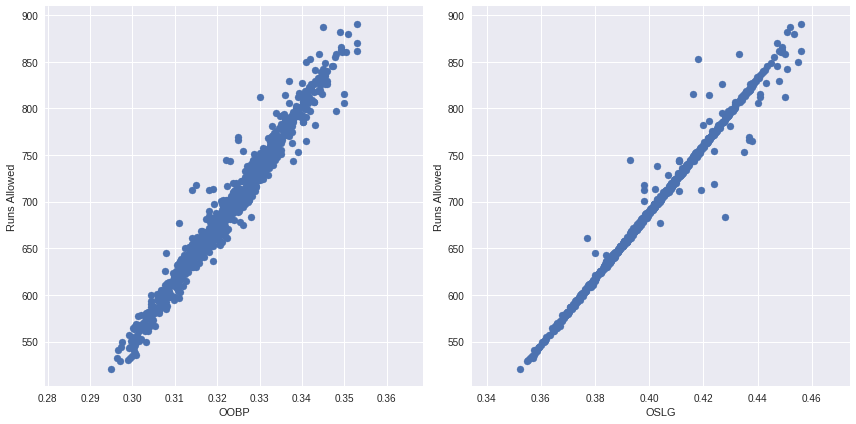

In [1628]:
plot_scatter(X_RA,y_RA,"Runs Allowed",2)

In [1629]:
# create train & test set for RA
XRA_train,XRA_test,yRA_train,yRA_test = train_test_split(X_RA,y_RA,test_size=0.2)

In [1630]:
# fit linear regression to RA dataset
regr_RA = LinearRegression()
regr_RA.fit(XRA_train,yRA_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

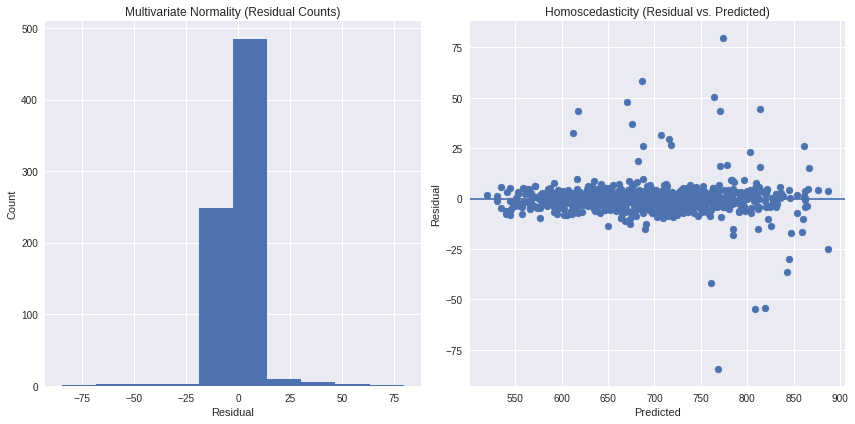

In [1631]:
# checking for multivariate normality & homoscedasticity
multi_norm_homo(X_RA,"RA",regr_RA,2)

The residual appears to follow a normal distribution, but there appears to be a weak homoscedastic relationship between residual and predicted values. 

In [1632]:
# evaluating model performance (RA)
print("Coefficients:\n",regr_RA.coef_)
print("\nIntercept:\n",regr_RA.intercept_)
print("\nR-squared:\n",regr_RA.score(XRA_test,yRA_test))

Coefficients:
 [2045.85413331 2398.74101388]

Intercept:
 -929.0551015135509

R-squared:
 0.9878167726466406


In [1633]:
# evaluating model performance with cross validation
cvs_RA = cross_val_score(estimator=regr_RA,X=X_RA,y=y_RA,cv=10)
print(cvs_RA)

[0.74881572 0.99739843 0.99665042 0.9975392  0.99705823 0.99586107
 0.99508234 0.99524828 0.99764803 0.99628642]


In [1634]:
# test individual parameters
linear_formula = 'RA ~ OOBP + OSLG'
lm = sm.ols(formula=linear_formula,data=pre_2002).fit()

In [1635]:
lm.pvalues

Intercept    3.646571e-311
OOBP          3.554394e-48
OSLG         6.420680e-154
dtype: float64

### Wins (W)

In [1636]:
X_W = pre_2002[["RD"]]
y_W = pre_2002["W"]

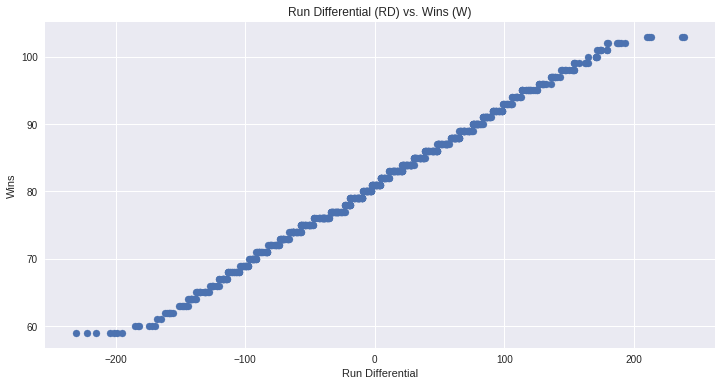

In [1637]:
# visualize relationship between RD and W
x_sort = sorted(X_W.values)
y_sort = sorted(y_W.values)
plt.scatter(x_sort,y_sort)
plt.ylabel("Wins")
plt.xlabel("Run Differential")
plt.title("Run Differential (RD) vs. Wins (W)")
plt.show()

In [1638]:
# create train & test set for W
XW_train,XW_test,yW_train,yW_test = train_test_split(X_W,y_W,test_size=0.2)

In [1639]:
# fit linear regression to W dataset
regr_W = LinearRegression()
regr_W.fit(XW_train,yW_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

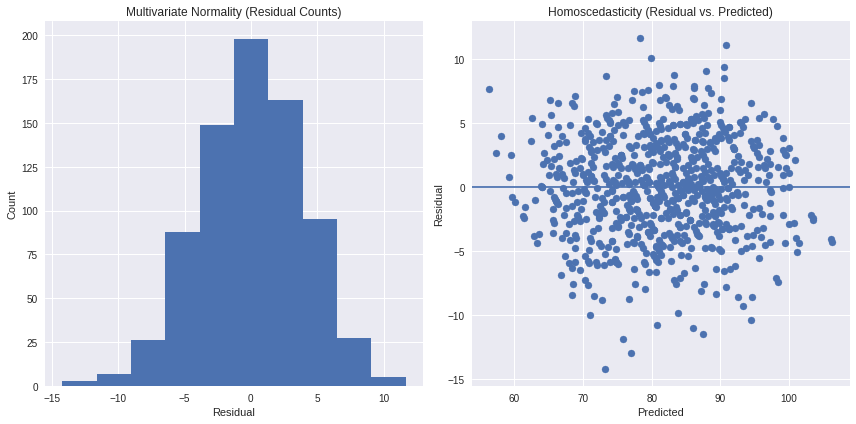

In [1640]:
# checking for multivariate normality & homoscedasticity
multi_norm_homo(X_W,"W",regr_W,2)

Appears the residual follows a normal distribution and there is a homoscedastic relationship between predicted and residual values. 

In [1641]:
# evaluating model performance (W)
print("Coefficients:\n",regr_W.coef_)
print("\nIntercept:\n",regr_W.intercept_)
print("\nR-squared:\n",regr_W.score(XW_test,yW_test))

Coefficients:
 [0.1063064]

Intercept:
 80.87951605937683

R-squared:
 0.850231248607522


In [1642]:
# evaluating model performance using cross-validation
cvs_W = cross_val_score(estimator=regr_W,X=X_W,y=y_W,cv=10)
print(cvs_W)

[0.90354023 0.79905102 0.85810646 0.82809896 0.82903313 0.8578853
 0.85316979 0.82510435 0.83389087 0.85336304]


In [1643]:
# test individual parameters
linear_formula = 'W ~ RD'
lm = sm.ols(formula=linear_formula,data=pre_2002).fit()

In [1644]:
lm.pvalues

Intercept     0.000000e+00
RD           4.628305e-313
dtype: float64

## Making Predictions

### Runs Scored (RS)

In [1645]:
RS_pred = regr_RS.predict(XRS_test)
RS_comp = pd.DataFrame({"Actual_RS":yRS_test,"Predicted_RS":RS_pred})
RS_comp.head(3)

,Actual_RS,Predicted_RS
597,728,696.813713
675,635,630.889533
687,798,721.055460


### Runs Allowed (RA)

In [1646]:
RA_pred = regr_RA.predict(XRA_test)
RA_comp = pd.DataFrame({"Actual_RA":yRA_test,"Predicted_RA":RA_pred})
RA_comp.head(3)

,Actual_RA,Predicted_RA
905,739,747.410362
1197,702,695.182065
656,734,736.096601


### Wins (W)

In [1647]:
W_pred = regr_W.predict(XW_test)
W_comp = pd.DataFrame({"Actual_W":yW_test,"Predicted_W":W_pred})
W_comp.head(3)

,Actual_W,Predicted_W
966,86,85.238078
857,79,83.218257
494,88,88.639883


## Improving predictions with other regression models

### Support Vector Regression (SVR)

In [1648]:
from sklearn.preprocessing import StandardScaler

# create function for scaling data
def scale_data(x,y):
    sc_x = StandardScaler()
    x_scale = sc_x.fit_transform(x)
    sc_y = StandardScaler()
    y_scale = sc_y.fit_transform(y.values.reshape(-1,1))
    return x_scale,y_scale,sc_y

In [1649]:
# scale data for SVR model

# RS
sc_RSX,sc_RSy,RSysc = scale_data(X_RS,y_RS)

# RA
sc_RAX,sc_RAy,RAysc = scale_data(X_RA,y_RA)
# W
sc_WX,sc_Wy,Wysc = scale_data(X_W,y_W)

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [1650]:
# create train & test data with scaled data

# RS
XRS_sc_train,XRS_sc_test,yRS_sc_train,yRS_sc_test = train_test_split(sc_RSX,sc_RSy,test_size=0.2)
# RA
XRA_sc_train,XRA_sc_test,yRA_sc_train,yRA_sc_test = train_test_split(sc_RAX,sc_RAy,test_size=0.2)
# W
XW_sc_train,XW_sc_test,yW_sc_train,yW_sc_test = train_test_split(sc_WX,sc_Wy,test_size=0.2)

In [1651]:
# fit SVR to datasets
from sklearn.svm import SVR
# RS
svr_RS = SVR()
svr_RS.fit(XRS_sc_train,yRS_sc_train.ravel())
# RA
svr_RA = SVR()
svr_RA.fit(XRA_sc_train,yRA_sc_train.ravel())
# W
svr_W = SVR()
svr_W.fit(XW_sc_train,yW_sc_train.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1652]:
# functions for evaluating model performance
def model_perform(xRS_test,xRA_test,xW_test,yRS_test,yRA_test,yW_test,model_RS,model_RA,model_W):
    print("RS (R^2): ",model_RS.score(xRS_test,yRS_test.ravel()))
    print("\nRA (R^2): ",model_RA.score(xRA_test,yRA_test.ravel()))
    print("\nW (R^2): ",model_W.score(xW_test,yW_test.ravel()))
def model_cv(xRS,xRA,xW,yRS,yRA,yW,model_RS,model_RA,model_W):
    print("RS Cross Validation Score:\n",cross_val_score(model_RS,xRS,yRS.ravel(),cv=6))
    print("\nRA Cross Validation Score:\n",cross_val_score(model_RA,xRA,yRA.ravel(),cv=6))
    print("\nW Cross Validation Score:\n",cross_val_score(model_W,xW,yW.ravel(),cv=6))

In [1653]:
# evaluate SVR model performance
model_perform(XRS_sc_test,XRA_sc_test,XW_sc_test,yRS_sc_test,yRA_sc_test,yW_sc_test,svr_RS,svr_RA,svr_W)

RS (R^2):  0.8397127270580922

RA (R^2):  0.976314720747962

W (R^2):  0.837944357838468


In [1654]:
# evaluate SVR model performance using cross validation
model_cv(sc_RSX,sc_RAX,sc_WX,sc_RSy,sc_RAy,sc_Wy,svr_RS,svr_RA,svr_W)

RS Cross Validation Score:
 [0.82971004 0.83374269 0.85535117 0.87809261 0.88156946 0.86045847]

RA Cross Validation Score:
 [0.89247263 0.99641691 0.99610701 0.99504152 0.99610061 0.9953595 ]

W Cross Validation Score:
 [0.85989281 0.85618749 0.81950154 0.85619276 0.82413445 0.85179183]


In [1655]:
svr_RS_pred = RSysc.inverse_transform(svr_RS.predict(XRS_sc_test))
svr_RA_pred = RAysc.inverse_transform(svr_RA.predict(XRA_sc_test))
svr_W_pred = Wysc.inverse_transform(svr_W.predict(XW_sc_test))

In [1656]:
# prediction comparisons
# RS 
svr_RS_comp = pd.DataFrame({'SVR_RS':RSysc.inverse_transform(yRS_sc_test).ravel(),'SVR_Pred_RS':svr_RS_pred})
svr_RS_comp.head(5)

,SVR_Pred_RS,SVR_RS
0,678.905891,702.0
1,614.547195,567.0
2,629.945497,651.0
3,735.124026,734.0
4,762.699136,741.0


In [1657]:
# RA 
svr_RA_comp = pd.DataFrame({"SVR_RA":RAysc.inverse_transform(yRA_sc_test).ravel(),"SVR_Pred_RA":svr_RA_pred})
svr_RA_comp.head(5)

,SVR_Pred_RA,SVR_RA
0,678.837140,674.0
1,554.036707,550.0
2,661.253792,657.0
3,646.218157,640.0
4,698.430406,697.0


In [1658]:
# W
svr_W_comp = pd.DataFrame({"SVR_W":Wysc.inverse_transform(yW_sc_test).ravel(),"SVR_Pred_W":svr_W_pred})
svr_W_comp.head(5)

,SVR_Pred_W,SVR_W
0,79.659100,85.0
1,71.458322,71.0
2,88.318895,85.0
3,80.779620,75.0
4,90.818443,95.0


### Random Forest (100 tree)

In [1659]:
from sklearn.ensemble import RandomForestRegressor

# RS
rf_regr_RS = RandomForestRegressor(n_estimators=100)
rf_regr_RS.fit(XRS_train,yRS_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1660]:
# RA
rf_regr_RA = RandomForestRegressor(n_estimators=100)
rf_regr_RA.fit(XRA_train,yRA_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1661]:
# W
rf_regr_W = RandomForestRegressor(n_estimators=100)
rf_regr_W.fit(XW_train,yW_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1662]:
# evaluate model performance
model_perform(XRS_test,XRA_test,XW_test,yRS_test,yRA_test,yW_test,rf_regr_RS,rf_regr_RA,rf_regr_W)

RS (R^2):  0.8431810278106622

RA (R^2):  0.9895718771565736

W (R^2):  0.82921167992127


In [1663]:
# evaluate model performance via cross validation
model_cv(X_RS,X_RA,X_W,y_RS,y_RA,y_W,rf_regr_RS,rf_regr_RA,rf_regr_W)

RS Cross Validation Score:
 [0.79894595 0.79629029 0.79882694 0.86488409 0.81711193 0.82388258]

RA Cross Validation Score:
 [0.86448767 0.99813484 0.99497236 0.99617672 0.99668078 0.99846399]

W Cross Validation Score:
 [0.80797887 0.80261739 0.77686312 0.83172823 0.75581822 0.77800606]


In [1664]:
# making predictions
rf_RS_pred = rf_regr_RS.predict(XRS_test)
rf_RA_pred = rf_regr_RA.predict(XRA_test)
rf_W_pred = rf_regr_W.predict(XW_test)

In [1665]:
# RS
rf_RS_comp = pd.DataFrame({"RF_RS":yRS_test,"RF_Pred_RS":rf_RS_pred})
rf_RS_comp.head(5)

,RF_Pred_RS,RF_RS
597,676.032000,728
675,637.385000,635
687,704.655000,798
977,738.794333,684
1082,632.140000,632


In [1666]:
# RA
rf_RA_comp = pd.DataFrame({"RF_RA":yRA_test,"RF_Pred_RA":rf_RA_pred})
rf_RA_comp.head(5)

,RF_Pred_RA,RF_RA
905,743.650,739
1197,701.780,702
656,733.040,734
1044,780.165,772
859,728.680,725


In [1667]:
# W
rf_W_comp = pd.DataFrame({"RF_W":yW_test,"RF_Pred_W":rf_W_pred})
rf_W_comp.head(5)

,RF_Pred_W,RF_W
966,85.950667,86
857,84.445238,79
494,86.778667,88
551,86.778667,96
1038,68.476000,67


In [1668]:
X_RS.columns[0]

'OBP'

### Boosting Model (XGboost)

In [1669]:
from xgboost import XGBRegressor as xgbr
X_RS = pre_2002[["OBP","SLG","BA"]]
y_RS = pre_2002["RS"]
def convert_features(list_features):
    df = pre_2002[list_features]
    
    if len(list_features) >= 2:
        df = df.rename(columns={df.columns[0]:"f0",df.columns[1]:"f1"})
        return df[["f0","f1"]]
    else:
        df = df.rename(columns={df.columns[0]:"f0"})
        return df[["f0"]]

In [1670]:
# convert feature column titles for XGBoost

# RS 
X1_RS = convert_features(["OBP","SLG"])

# RA
X1_RA = convert_features(["OOBP","OSLG"])

# W
X1_W = convert_features(["RD"])

In [1671]:
# create train & test data

# RS
XG_RSx_train,XG_RSx_test,XG_RSy_train,XG_RSy_test = train_test_split(X1_RS,y_RS,test_size=0.25)

# RA
XG_RAx_train,XG_RAx_test,XG_RAy_train,XG_RAy_test = train_test_split(X1_RA,y_RA,test_size=0.25)

# W
XG_Wx_train,XG_Wx_test,XG_Wy_train,XG_Wy_test = train_test_split(X1_W,y_W,test_size=0.25)

In [1672]:
# fit XGBoost model to data

# RS
xg_RS = xgbr()
xg_RS.fit(XG_RSx_train.values,XG_RSy_train.values.ravel())
# RA
xg_RA = xgbr()
xg_RA.fit(XG_RAx_train.values,XG_RAy_train.values.ravel())
# W
xg_W = xgbr()
xg_W.fit(XG_Wx_train.values,XG_Wy_train.values.ravel())

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [1673]:
# evaluate model performance
model_perform(XG_RSx_test,XG_RAx_test,XG_Wx_test,XG_RSy_test,XG_RAy_test,XG_Wy_test,xg_RS,xg_RA,xg_W)

RS (R^2):  0.88466327452219

RA (R^2):  0.9781085513605052

W (R^2):  0.8607424805971111


In [1674]:
# evaluate XGBoost model performance using cross validation
model_cv(X_RS,X_RA,X_W,y_RS,y_RA,y_W,xg_RS,xg_RA,xg_W)

RS Cross Validation Score:
 [0.83186891 0.82081796 0.83010867 0.86828679 0.85818314 0.85761067]

RA Cross Validation Score:
 [0.86360891 0.99649784 0.99576192 0.99324526 0.99672688 0.99685829]

W Cross Validation Score:
 [0.84755502 0.84883454 0.81131319 0.8553547  0.81585562 0.83998291]


In [1675]:
# make predictions
xg_RS_pred = xg_RS.predict(XG_RSx_test)
xg_RA_pred = xg_RA.predict(XG_RAx_test)
xg_W_pred = xg_W.predict(XG_Wx_test)

In [1676]:
# RS
xg_RS_comp = pd.DataFrame({"xg_RS":XG_RSy_test,"xg_Pred_RS":xg_RS_pred})
xg_RS_comp.head(5)

,xg_Pred_RS,xg_RS
757,656.822021,652
1170,643.891541,707
1073,631.824890,625
1060,658.004944,680
958,734.122009,710


In [1677]:
# RA
xg_RA_comp = pd.DataFrame({"xg_RA":XG_RAy_test,"xg_Pred_RA":xg_RA_pred})
xg_RA_comp.head(5)

,xg_Pred_RA,xg_RA
758,679.370239,679
936,657.111267,655
1200,704.271423,704
510,739.697327,739
332,638.668701,643


In [1678]:
# W
rf_W_comp = pd.DataFrame({"xg_W":XG_Wy_test,"xg_Pred_W":xg_W_pred})
rf_W_comp.head(5)

,xg_Pred_W,xg_W
993,70.979408,72
576,71.019691,71
711,67.028419,67
454,70.402626,68
692,91.711136,95


## Checking for Overfitting (RMSE)

### Linear Regression

In [1679]:
from sklearn import metrics

def rmse_fit(xtrain,xtest,ytrain,ytest,model):
    pred_train = model.predict(xtrain)
    pred_test = model.predict(xtest)
    rmse_train = np.sqrt(metrics.mean_squared_error(ytrain,pred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(ytest,pred_test))
    print("RMSE (train): ",rmse_train)
    print("RMSE (test): ",rmse_test)

def svr_rmse_fit(xtrain,xtest,ytrain,ytest,model,svr_sc_mod):
    pred_train = svr_sc_mod.inverse_transform(model.predict(xtrain))
    pred_test = svr_sc_mod.inverse_transform(model.predict(xtest))
    rmse_train = np.sqrt(metrics.mean_squared_error(svr_sc_mod.inverse_transform(ytrain).ravel(),pred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(svr_sc_mod.inverse_transform(ytest).ravel(),pred_test))
    print("RMSE (train): ",rmse_train)
    print("RMSE (test): ",rmse_test)

In [1680]:
# RS
rmse_fit(XRS_train,XRS_test,yRS_train,yRS_test,regr_RS)

RMSE (train):  24.43540019177694
RMSE (test):  24.587191025166582


In [1681]:
# use K-fold cross validation to create train-test sets
#from sklearn.cross_validation import KFold
#kf = KFold(len(y_RS),2)
#kf.get_n_splits(X_RS)

#for train_indices, test_indices in kf:
    #XRS_train2 = [X_RS[i] for i in train_indices]
    #XRS_test2 = [X_RS[i] for i in test_indices]
    #yRS_train2 = [y_RS[i] for i in train_indices]
   #yRS_test2 = [y_RS[i] for i in test_indices]

In [1682]:
# rmse_fit(XRS_train2,XRS_test2,yRS_train,yRS_test,regr_RS)

In [1683]:
# RA
rmse_fit(XRA_train,XRA_test,yRA_train,yRA_test,regr_RA)

RMSE (train):  8.838230483332858
RMSE (test):  8.866032225418069


In [1684]:
# W
rmse_fit(XW_train,XW_test,yW_train,yW_test,regr_W)

RMSE (train):  3.939469025852472
RMSE (test):  3.857567843273761


### SVR

In [1685]:
# RS
svr_rmse_fit(XRS_sc_train,XRS_sc_test,yRS_sc_train,yRS_sc_test,svr_RS,RSysc)

RMSE (train):  23.92105962683614
RMSE (test):  24.889267062435234


In [1686]:
# RA
svr_rmse_fit(XRA_sc_train,XRA_sc_test,yRA_sc_train,yRA_sc_test,svr_RA,RAysc)

RMSE (train):  7.761761423243637
RMSE (test):  11.395229823502927


In [1687]:
# W
svr_rmse_fit(XW_sc_train,XW_sc_test,yW_sc_train,yW_sc_test,svr_W,Wysc)

RMSE (train):  3.9047788363642426
RMSE (test):  3.8587865582060368


### Random Forest

In [1688]:
# RS
rmse_fit(XRS_train,XRS_test,yRS_train,yRS_test,rf_regr_RS)

RMSE (train):  12.306912603547161
RMSE (test):  29.553744178470314


In [1689]:
# RA
rmse_fit(XRA_train,XRA_test,yRA_train,yRA_test,rf_regr_RA)

RMSE (train):  3.655685150138176
RMSE (test):  8.20259370505427


In [1690]:
# W
rmse_fit(XW_train,XW_test,yW_train,yW_test,rf_regr_W)

RMSE (train):  3.036720305277634
RMSE (test):  4.119381853727456


### XGBoost

In [1691]:
# RS
rmse_fit(XG_RSx_train,XG_RSx_test,XG_RSy_train,XG_RSy_test,xg_RS)

RMSE (train):  21.384856294561864
RMSE (test):  24.69969012453022


In [1692]:
# RA
rmse_fit(XG_RAx_train,XG_RAx_test,XG_RAy_train,XG_RAy_test,xg_RA)

RMSE (train):  4.617543975850119
RMSE (test):  11.077993142895753


In [1693]:
# W
rmse_fit(XG_Wx_train,XG_Wx_test,XG_Wy_train,XG_Wy_test,xg_W)

RMSE (train):  3.545029565764378
RMSE (test):  3.9220222629560912


## Tuning hyperparameters for SVR, RandomForest & XGBoost

### I. RandomizedSearchCV

### SVR

In [1694]:
# from sklearn.model_selection import RandomizedSearchCV

# # penalty parameter of the error term (C)
# c_param = [int(x) for x in np.linspace(start=1,stop=1000,num=100)]
# # kernel type to be used for SVR
# kernel_param = ["linear","rbf"]
# # kernel coefficient (gamma)
# gamma_param = [x for x in np.linspace(start=0.001,stop=1,num=100)]

# # create random grid
# svr_random_grid = {
#     "C":c_param,
#     "kernel":kernel_param,
#     "gamma":gamma_param
# }

In [1695]:
# search for best hyperparameters using 10-fold cross validation 

# RS
# svr_RS_random = RandomizedSearchCV(estimator=svr_RS,param_distributions=svr_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# svr_RS_random.fit(XRS_sc_train,yRS_sc_train.ravel())

In [1696]:
# svr_RS_random.best_params_

In [1697]:
# RA
# svr_RA_random = RandomizedSearchCV(estimator=svr_RA,param_distributions=svr_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# svr_RA_random.fit(XRA_sc_train,yRA_sc_train.ravel())

In [1698]:
# svr_RA_random.best_params_

In [1699]:
# W
# svr_W_random = RandomizedSearchCV(estimator=svr_W,param_distributions=svr_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# svr_W_random.fit(XW_sc_train,yW_sc_train.ravel())

In [1700]:
#svr_W_random.best_params_

### Random Forest

In [1701]:
# # number of trees
# n_param = [int(x) for x in np.linspace(start=10,stop=1000,num=100)]
# # criterion
# #crit_param = ["mse","mae"]
# # number of features to consider at every split
# max_features = ["auto","sqrt"]
# # max number of levels in tree
# max_depth = [int(x) for x in np.linspace(10,110,num=100)]
# max_depth.append(None)
# # min number of samples required to split a node
# min_samples_split = [2,5,10]
# # min number of samples required at each leaf node
# min_samples_leaf = [1,2,4]
# # method of selecting samples for training each tree
# bootstrap = [True,False]

# # create the random grid
# rf_random_grid = {
#     'n_estimators':n_param,
#     #'criterion': crit_param,
#     'max_features': max_features,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf,
#     'bootstrap' : bootstrap
# }

In [1702]:
# RS
# rf_RS_random = RandomizedSearchCV(estimator=rf_regr_RS,param_distributions=rf_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# rf_RS_random.fit(XRS_train,yRS_train)

In [1703]:
# rf_RS_random.best_params_

In [1704]:
# RA
# rf_RA_random = RandomizedSearchCV(estimator=rf_regr_RA,param_distributions=rf_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# rf_RA_random.fit(XRA_train,yRA_train)

In [1705]:
# rf_RA_random.best_params_

In [1706]:
# W
# rf_W_random = RandomizedSearchCV(estimator=rf_regr_W,param_distributions=rf_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# rf_W_random.fit(XW_train,yW_train)

In [1707]:
# rf_W_random.best_params_

### XGBoost

In [1708]:
# # learning rate
# learning_rate = [x for x in np.linspace(start=0.01,stop=1,num=100)]
# # number of trees
# n_estimators = [int(x) for x in np.linspace(start=10,stop=1000,num=100)]
# # max number of levels in tree
# max_depth = range(3,10,2)
# # gamma
# gamma_param = [x for x in np.linspace(start=0.001,stop=1,num=100)]
# # min child weight
# min_child_weight = range(1,6,2)
# # subsample
# #sub_sample = [(x/10) for x in range(6,10)]
# # colsample by tree
# #colsample_bytree = [(x/10) for x in range(6,10)]

# # create the random grid
# xg_random_grid = {
#     'learning_rate':learning_rate,
#     'n_estimators':n_estimators,
#     'max_depth': max_depth,
#     'min_child_weight':min_child_weight,
#     #'sub_sample': sub_sample,
#     #'colsample_bytree':colsample_bytree,
#     #'scale_pos_weight' : scale_pos_weight
# }

In [1709]:
# RS
# xg_RS_random = RandomizedSearchCV(estimator=xg_RS,param_distributions=xg_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# xg_RS_random.fit(XG_RSx_train.values,XG_RSy_train.values.ravel())

In [1710]:
# xg_RS_random.best_params_

In [1711]:
# RA
# xg_RA_random = RandomizedSearchCV(estimator=xg_RA,param_distributions=xg_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# xg_RA_random.fit(XG_RAx_train.values,XG_RAy_train.values.ravel())

In [1712]:
# xg_RA_random.best_params_

In [1713]:
# W
# xg_W_random = RandomizedSearchCV(estimator=xg_W,param_distributions=xg_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
# xg_W_random.fit(XG_Wx_train.values,XG_Wy_train.values.ravel())

In [1714]:
# xg_W_random.best_params_

### II. GridSearch

### SVR

In [1715]:
#from sklearn.model_selection import GridSearchCV

# RS
#svr_RS_grid = GridSearchCV(estimator=svr_RS,param_grid=svr_random_grid,cv=3,verbose=2,n_jobs=-1)
#svr_RS_grid.fit(XRS_sc_train,yRS_sc_train.ravel())

In [1716]:
#svr_RS_grid.best_params_

In [1717]:
# RA
#svr_RA_grid = GridSearchCV(estimator=svr_RA,param_grid=svr_random_grid,cv=3,verbose=2,n_jobs=-1)
#svr_RA_grid.fit(XRA_sc_train,yRA_sc_train.ravel())

In [1718]:
#svr_RA_grid.best_params_

## Applying changes to models' hyperparameters

In [1719]:
# # evaluate random search
# def evaluate_svr(model,scale,test_features,test_labels):
#     predictions = scale.inverse_transform(model.predict(test_features))
#     errors = abs(predictions-(scale.inverse_transform(test_labels).ravel()))
#     mape = 100*np.mean(errors/(scale.inverse_transform(test_labels).ravel()))
#     accuracy = 100 - mape
#     print("Model Performance")
#     print("Average Error: {:0.4f} degrees.".format(np.mean(errors)))
#     print("Accuracy = {:0.2f}%".format(accuracy))
#     print(mape)
#     return accuracy

# def evaluate(model,test_features,test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions-test_labels)
#     mape = 100*np.mean(errors/test_labels)
#     accuracy = 100 - mape
#     print("Model Performance")
#     print("Average Error: {:0.4f} degrees.".format(np.mean(errors)))
#     print("Accuracy = {:0.2f}%".format(accuracy))
#     print(mape)
#     return accuracy

# def update_param_svr(param_dic,model_type):
#     p = param_dic
#     return model_type(C=p["C"],gamma=p["gamma"],kernel=p["kernel"])

# def update_param_rf(param_dic,model_type):
#     p = param_dic
#     return model_type(bootstrap=p["bootstrap"],max_depth=p["max_depth"],max_features=p["max_features"],min_samples_leaf=p["min_samples_leaf"],min_samples_split=p["min_samples_split"],n_estimators=p["n_estimators"])

# def update_param_xg(param_dic,model_type):
#     p = param_dic
#     return model_type(learning_rate=p["learning_rate"],max_depth=p["max_depth"],min_child_weight=p["min_child_weight"],n_estimators=p["n_estimators"])


### SVR

In [1720]:
# # RS
# svr_RS2 = update_param_svr(svr_RS_random.best_params_,SVR)
# svr_RS2.fit(XRS_sc_train,yRS_sc_train.ravel())
# # RA
# svr_RA2 = update_param_svr(svr_RA_random.best_params_,SVR)
# svr_RA2.fit(XRA_sc_train,yRA_sc_train.ravel())
# # W
# svr_W2 = update_param_svr(svr_W_random.best_params_,SVR)
# svr_W2.fit(XW_sc_train,yW_sc_train.ravel())

In [1721]:
# # RS 
# base_svr_RS = evaluate_svr(svr_RS,RSysc,XRS_sc_test,yRS_sc_test)
# print("")
# enhan_svr_RS = evaluate_svr(svr_RS2,RSysc,XRS_sc_test,yRS_sc_test)

In [1722]:
# print("Improvement of {:0.2f}%".format(100*(enhan_svr_RS-base_svr_RS)/base_svr_RS))

In [1723]:
# # RA
# base_svr_RA = evaluate_svr(svr_RA,RAysc,XRA_sc_test,yRA_sc_test)
# print("")
# enhan_svr_RA = evaluate_svr(svr_RA2,RAysc,XRA_sc_test,yRA_sc_test)

In [1724]:
# print("Improvement of {:0.2f}%".format(100*(enhan_svr_RA-base_svr_RA)/base_svr_RA))

In [1725]:
# # W
# base_svr_W = evaluate_svr(svr_W,Wysc,XW_sc_test,yW_sc_test)
# print("")
# enhan_svr_W = evaluate_svr(svr_W2,Wysc,XW_sc_test,yW_sc_test)

In [1726]:
# print("Improvement of {:0.2f}%".format(100*(enhan_svr_W-base_svr_W)/base_svr_W))

### Random Forest

In [1727]:
# # RS
# rf_regr_RS2 = update_param_rf(rf_RS_random.best_params_,RandomForestRegressor)
# rf_regr_RS2.fit(XRS_train,yRS_train)

# # RA
# rf_regr_RA2 = update_param_rf(rf_RA_random.best_params_,RandomForestRegressor)
# rf_regr_RA2.fit(XRA_train,yRA_train)

# # W
# rf_regr_W2 = update_param_rf(rf_W_random.best_params_,RandomForestRegressor)
# rf_regr_W2.fit(XW_train,yW_train)

In [1728]:
# # RS 
# base_rf_RS = evaluate(rf_regr_RS,XRS_test,yRS_test)
# print("")
# enhan_rf_RS = evaluate(rf_regr_RS2,XRS_test,yRS_test)

In [1729]:
# print("Improvement of {:0.2f}%".format(100*(enhan_rf_RS-base_rf_RS)/base_rf_RS))

In [1730]:
# # RA
# base_rf_RA = evaluate(rf_regr_RA,XRA_test,yRA_test)
# print("")
# enhan_rf_RA = evaluate(rf_regr_RA2,XRA_test,yRA_test)

In [1731]:
# print("Improvement of {:0.2f}%".format(100*(enhan_rf_RA-base_rf_RA)/base_rf_RA))

In [1732]:
# # W
# base_rf_W = evaluate(rf_regr_W,XW_test,yW_test)
# print("")
# enhan_rf_W = evaluate(rf_regr_W2,XW_test,yW_test)

In [1733]:
# print("Improvement of {:0.2f}%".format(100*(enhan_rf_W-base_rf_W)/base_rf_W))

### XGBoost

In [1734]:
# # RS
# xg_RS2 = update_param_xg(xg_RS_random.best_params_,xgbr)
# xg_RS2.fit(XG_RSx_train.values,XG_RSy_train.values.ravel())
# # RA
# xg_RA2 = update_param_xg(xg_RA_random.best_params_,xgbr)
# xg_RA2.fit(XG_RAx_train,XG_RAy_train)
# # W
# xg_W2 = update_param_xg(xg_W_random.best_params_,xgbr)
# xg_W2.fit(XG_Wx_train,XG_Wy_train)

In [1735]:
# # RS
# base_xg_RS = evaluate(xg_RS,XG_RSx_test.values,XG_RSy_test.values.ravel())
# print("")
# enhan_xg_RS = evaluate(xg_RS2,XG_RSx_test.values,XG_RSy_test.values.ravel())

In [1736]:
# print("Improvement of {:0.2f}%".format(100*(enhan_xg_RS-base_xg_RS)/base_xg_RS))

In [1737]:
# # RA
# base_xg_RA = evaluate(xg_RA,XG_RAx_test.values,XG_RAy_test.values.ravel())
# print("")
# enhan_xg_RA = evaluate(xg_RA2,XG_RAx_test.values,XG_RAy_test.values.ravel())

In [1738]:
# print("Improvement of {:0.2f}%".format(100*(enhan_xg_RA-base_xg_RA)/base_xg_RA))

In [1739]:
# # W
# base_xg_W = evaluate(xg_W,XG_Wx_test.values,XG_Wy_test.values.ravel())
# print("")
# enhan_xg_W = evaluate(xg_W2,XG_Wx_test.values,XG_Wy_test.values.ravel())

In [1740]:
# print("Improvement of {:0.2f}%".format(100*(enhan_xg_W-base_xg_W)/base_xg_W))

## Predictions for MLB 2002 season

In [1741]:
post_2002.head(3)

,RS,RA,W,OBP,SLG,BA,OOBP,OSLG,Year,Team,RD
300,851,644,99,0.341,0.433,0.282,0.314,0.392,2002,ANA,207
301,819,674,98,0.346,0.423,0.267,0.305,0.397,2002,ARI,145
302,708,565,101,0.331,0.409,0.260,0.313,0.364,2002,ATL,143


### Linear Regression

In [1742]:
# RS
XRS_2002 = post_2002[["OBP","SLG","BA"]]
yRS_2002 = post_2002["RS"]
RSpred_2002 = regr_RS.predict(XRS_2002)
RScomp_2002 = pd.DataFrame({"Actual_RS":yRS_2002,"Predicted_RS":RSpred_2002})
RScomp_2002["Team"] = post_2002["Team"]
RScomp_2002.head(3)

ValueError: shapes (23,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0)

In [ ]:
# RA
XRA_2002 = post_2002[["OOBP","OSLG"]]
yRA_2002 = post_2002["RA"]
RApred_2002 = regr_RA.predict(XRA_2002)
RAcomp_2002 = pd.DataFrame({"Actual_RA":yRA_2002,"Predicted_RA":RApred_2002})
RAcomp_2002["Team"] = post_2002["Team"]
RAcomp_2002.head(3)

In [ ]:
XRA_2002.shape

In [ ]:
# W
XRD_2002 = post_2002[["RD"]]
yW_2002 = post_2002["W"]
Wpred_2002 = regr_W.predict(XRD_2002)
Wcomp_2002 = pd.DataFrame({"Actual_W":yW_2002,"Predicted_W":Wpred_2002})
Wcomp_2002["Team"] = post_2002["Team"]
Wcomp_2002.head(3)

### SVR

In [ ]:
# RS
scRSX_2002,scRSy_2002,RSysc_2002 = scale_data(XRS_2002,yRS_2002)

# RA
scRAX_2002,scRAy_2002,RAysc_2002 = scale_data(XRA_2002,yRA_2002)
# W
scRDX_2002,scWy_2002,Wysc_2002 = scale_data(XRD_2002,yW_2002)

svrRS_pred_2002 = RSysc_2002.inverse_transform(svr_RS.predict(scRSX_2002))
svrRA_pred_2002 = RAysc_2002.inverse_transform(svr_RA.predict(scRAX_2002))
svrW_pred_2002 = Wysc_2002.inverse_transform(svr_W.predict(scRDX_2002))

In [ ]:
# RS
svrRS_comp_2002 = pd.DataFrame({'SVR_RS':RSysc_2002.inverse_transform(scRSy_2002).ravel(),'SVR_Pred_RS':svrRS_pred_2002})
svrRS_comp_2002.head(5)

In [ ]:
# RA
svrRA_comp_2002 = pd.DataFrame({'SVR_RA':RAysc_2002.inverse_transform(scRAy_2002).ravel(),'SVR_Pred_RA':svrRA_pred_2002})
svrRA_comp_2002.head(5)

In [ ]:
# W
svrW_comp_2002 = pd.DataFrame({'SVR_W':Wysc_2002.inverse_transform(scWy_2002).ravel(),'SVR_Pred_W':svrW_pred_2002})
svrW_comp_2002.head(5)

### Random Forest

In [ ]:
# making predictions
rfRS_pred_2002 = rf_regr_RS.predict(XRS_2002)
rfRA_pred_2002 = rf_regr_RA.predict(XRA_2002)
rfW_pred_2002 = rf_regr_W.predict(XRD_2002)

In [ ]:
# RS
svrRS_comp_2002 = pd.DataFrame({'RandomForest_RS':yRS_2002,'RandomForest_Pred_RS':rfRS_pred_2002})
svrRS_comp_2002["Team"] = post_2002["Team"]
svrRS_comp_2002.head(5)

In [ ]:
# RA
svrRA_comp_2002 = pd.DataFrame({'RandomForest_RA':yRA_2002,'RandomForest_Pred_RS':rfRA_pred_2002})
svrRA_comp_2002["Team"] = post_2002["Team"]
svrRA_comp_2002.head(5)

In [ ]:
# W
svrW_comp_2002 = pd.DataFrame({'RandomForest_W':yW_2002,'RandomForest_Pred_W':rfW_pred_2002})
svrW_comp_2002["Team"] = post_2002["Team"]
svrW_comp_2002.head(5)

### XGBoost

In [ ]:
def convert_features_2002(list_features):
    df = post_2002[list_features]
    
    if len(list_features) >= 2:
        df = df.rename(columns={df.columns[0]:"f0",df.columns[1]:"f1"})
        return df[["f0","f1"]]
    else:
        df = df.rename(columns={df.columns[0]:"f0"})
        return df[["f0"]]

In [ ]:
# RS 
X1RS_2002 = convert_features_2002(["OBP","SLG"])

# RA
X1RA_2002 = convert_features_2002(["OOBP","OSLG"])

# W
X1W_2002 = convert_features_2002(["RD"])

In [ ]:
xgRS_pred_2002 = xg_RS.predict(X1RS_2002)
xgRA_pred_2002 = xg_RA.predict(X1RA_2002)
xgW_pred_2002 = xg_W.predict(X1W_2002)

In [ ]:
# RS
svrRS_comp_2002 = pd.DataFrame({'xg_RS':yRS_2002,'XGBoost_Pred_RS':xgRS_pred_2002})
svrRS_comp_2002["Team"] = post_2002["Team"]
svrRS_comp_2002.head(5)

In [ ]:
# RA
svrRA_comp_2002 = pd.DataFrame({'xg_RA':yRA_2002,'XGBoost_Pred_RS':xgRA_pred_2002})
svrRA_comp_2002["Team"] = post_2002["Team"]
svrRA_comp_2002.head(5)

In [ ]:
# W
svrW_comp_2002 = pd.DataFrame({'xg_W':yW_2002,'XGBoost_Pred_W':xgW_pred_2002})
svrW_comp_2002["Team"] = post_2002["Team"]
svrW_comp_2002.head(5)